## Тех. задние
______
На базе HorsesOrHumans (которая есть в открытом доступе библиотеки tensorflow) постройте автокодировщик. Предобучите автокодировщик. Возьмите предобученный encoder. Кластеризуйте скрытое пространство на два кластера, полученное из encoder (т.е. кластеризовать изображения, так как при подаче изображения на вход encoder’у получится скрытое пространство).
Проверьте насколько точно произошла кластеризация картинок лошадей и людей по двум классам.

Мы не ждём от Вас высокой точности сети, это будет проверка на взаимодействие, понимание задания и подход к обработке базы.


### Импортируем библиотеки

In [2]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score

import pandas as pd
import numpy as np

from tqdm import tqdm
import os
import shutil

import seaborn as sns

import matplotlib.image as implt
import matplotlib.pyplot as plt

# (Python Image Library) https://python-scripts.com/pillow
from PIL import Image

## Прописываем нужные функции

In [9]:
# Function to Extract features from the image

def image_predict(train_path):
    img_path = os.listdir(train_path)
    model = InceptionV3(weights='imagenet', include_top=False)
    features = []
    img_name = []
    for j in tqdm(img_path):
        direc = train_path + '/' + j + '/'
        for i in os.listdir(direc):
            img = tf.io.read_file(direc+i)  # берем каждый рисунок
            x = tf.image.decode_png(img, channels=3)
            x = np.expand_dims(x, axis=0)  # добавим 4-е пространство
            x = preprocess_input(x)  # нормализуем для InceptionV3
            feat = model.predict(x)
            feat = feat.flatten()
            features.append(feat)
            img_name.append(j)
    return features, img_name

In [ ]:
# Build table of metrics (confusion matrix)


def metric(y_test, y_pred):
    dict_metrics = {}
    P = np.sum(y_test == 1)
    N = np.sum(y_test == 0)
    TP = np.sum((y_test == 0) & (y_pred == 0))
    TN = np.sum((y_test == 1) & (y_pred == 1))
    FP = np.sum((y_test == 0) & (y_pred == 1))
    FN = np.sum((y_test == 1) & (y_pred == 0))
    dict_metrics['P'] = ['Positive', P, 'Лошади']
    dict_metrics['N'] = ['Negative', N, 'Люди']
    dict_metrics['TP'] = ['True positive', TP, 'Истинно люди']
    dict_metrics['TN'] = ['True Negative', TN, 'Истинно лошади']
    dict_metrics['FP'] = ['False Positive', FP, 'Ложно люди']
    dict_metrics['FN'] = ['False Negative', FN, 'Ложно лошади']
    dict_metrics['Accuracy'] = ['Accuracy', accuracy_score(
        y_test, y_pred), 'Accuracy=(TP+TN)/(TP+TN+FP+FN)']
    dict_metrics['Precision'] = ['Precision', precision_score(
        y_test, y_pred), 'Точность = TP/(TP+FP)']
    dict_metrics['Recall'] = ['Recall', recall_score(
        y_test, y_pred), 'Полнота = TP/(TP+FN)']
    dict_metrics['F1-score'] = ['F-мера',
                                f1_score(y_test, y_pred), 'Среднее гармоническое Precision и Recall']
    Accuracy = accuracy_score(y_test, y_pred)
    Recall = recall_score(y_test, y_pred)

    temp_df = pd.DataFrame.from_dict(dict_metrics, orient='index', columns=[
        'Metrics', 'Result', 'Description'])
    display(temp_df)

## Прописываем путь к данным

In [3]:
path_drive = "/content/drive/MyDrive/ТЗ_УИИ/"
path_jupyter = "C:/Users/DS_PC/Google Диск/ТЗ_УИИ/"

train_path = path_jupyter + "train"
test_path = path_jupyter + "validation"

train_horses = path_jupyter + "train/horses/"
# test_horses = "/content/drive/MyDrive/ТЗ_УИИ/validation/horses/"

train_humans = path_jupyter + "train/humans/"
# test_humans = "/content/drive/MyDrive/ТЗ_УИИ/validation/humans/"

horses 500
humans 527


Text(0.5, 1.0, 'Кол-во изображений для тренировочной')

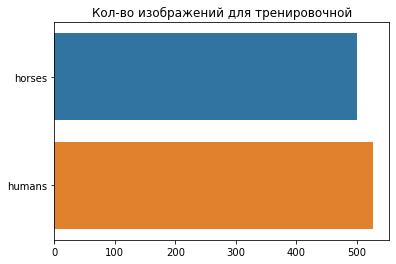

In [4]:
# Смотрим сколько людей и лошадей (Люди, кони.. - все смешалось! :) )
category_names = os.listdir(train_path)  # output: ['humans', 'horses']
nb_categories = len(category_names)  # output: 2
train_images = []

for category in category_names:
    folder = train_path + "/" + category
    train_images.append(len(os.listdir(folder)))
    print(f"{category}", len(os.listdir(folder)))

sns.barplot(y=category_names, x=train_images).set_title(
    "Кол-во изображений для тренировочной")

horses 128
humans 128


Text(0.5, 1.0, 'Кол-во изображений для теста')

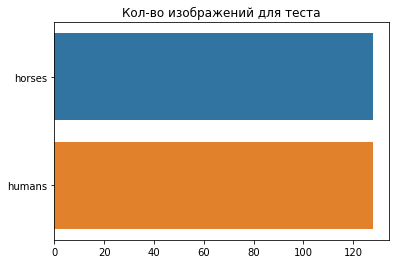

In [5]:
test_images = []
for category in category_names:
    folder = test_path + "/" + category
    test_images.append(len(os.listdir(folder)))
    print(f"{category}", len(os.listdir(folder)))
sns.barplot(y=category_names, x=test_images).set_title(
    "Кол-во изображений для теста")

# Смотрим картинки

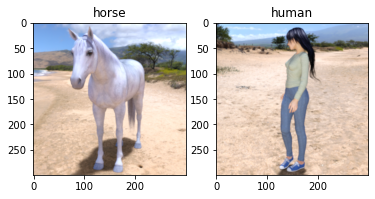

In [6]:
img1 = implt.imread(train_horses + "/horse01-0.png")
img2 = implt.imread(train_humans + "/human01-00.png")

plt.subplot(1, 2, 1)
plt.title('horse')
plt.imshow(img1)
plt.subplot(1, 2, 2)
plt.title("human")
plt.imshow(img2)
plt.show()

In [7]:
humans = Image.open(train_horses + "/horse01-0.png")
pix = humans.load()
print('размер картинки', humans.size)

размер картинки (300, 300)


In [41]:
os.listdir(train_path)[0]

'horses'

## Препроцессинг
____
Я использовал InceptionV3 основываясь на [документации](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb#scrollTo=zXR0217aRPFR)


In [10]:
img_features, img_name = image_predict(train_path)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [04:19<00:00, 130.00s/it]


## Кластеризация 

In [11]:
k = 2  # мы знаем что у нас 2 класса
clusters = KMeans(k, random_state=40)
clusters.fit(img_features)

KMeans(n_clusters=2, random_state=40)

In [12]:
image_cluster = pd.DataFrame(img_name, columns=['image'])
image_cluster["clusterid"] = clusters.labels_
image_cluster  # 0 denotes cat and 1 denotes dog

,image,clusterid
0,horses,1
1,horses,1
2,horses,1
3,horses,1
4,horses,1
...,...,...
1022,humans,0
1023,humans,0
1024,humans,0
1025,humans,0


In [30]:
image_cluster.clusterid.value_counts()

0    529
1    498
Name: clusterid, dtype: int64

## Метрика
____

In [27]:
y_test = image_cluster.image.apply(lambda x: 1 if x == 'horses' else 0)
y_pred = clusters.labels_

In [37]:
metric(y_test, y_pred)

,Metrics,Result,Description
P,Positive,500.000000,Лошади
N,Negative,527.000000,Люди
TP,True positive,527.000000,Истинно люди
TN,True Negative,498.000000,Истинно лошади
FP,False Positive,0.000000,Ложно люди
FN,False Negative,2.000000,Ложно лошади
Accuracy,Accuracy,0.998053,Accuracy=(TP+TN)/(TP+TN+FP+FN)
Precision,Precision,1.000000,Точность = TP/(TP+FP)
Recall,Recall,0.996000,Полнота = TP/(TP+FN)
F1-score,F-мера,0.997996,Среднее гармоническое Precision и Recall


## Заключение - практически полностью распознали людей и лошадей.

In [38]:
# Прочие метрики..
print("Коэффициент силуэта: %0.3f" % metrics.silhouette_score(img_features,
                                                              y_pred, metric='euclidean'))
print("Однородность: %0.3f" % metrics.homogeneity_score(img_name, y_pred))
print("Полнота: %0.3f" % metrics.completeness_score(img_name, y_pred))
print("V-мера: %0.3f" % metrics.v_measure_score(img_name, y_pred))

Коэффициент силуэта: 0.088
Однородность: 0.982
Полнота: 0.982
V-мера: 0.982


In [39]:
img_features_array = np.asarray(img_features)

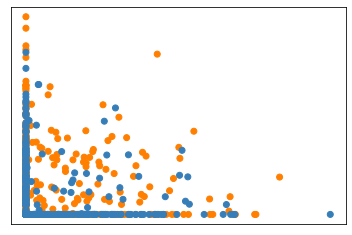

In [40]:
y_pred = clusters.labels_.astype(np.int)
plt.subplot()
plt.xticks([])
plt.yticks([])

colors = np.array(list(['#377eb8', '#ff7f00']))
plt.scatter(img_features_array[:, 0],
            img_features_array[:, 1], color=colors[y_pred])